# OpenWeather EDA — BigQuery + Colab

This notebook connects to **BigQuery**, pulls data from your `openweather_15_cities` table, and runs **exploratory data analysis** with **SQL + pandas + matplotlib**.

In [5]:
try:
    from google.colab import auth
    auth.authenticate_user()
    print("Authenticated with Google.")
except Exception:
    print("Not running on Colab or already authenticated.")


Authenticated with Google.


In [6]:

# --- CONFIGURATION --- #
PROJECT_ID = "airflowbigqueryproject"
DATASET    = "airflow_bq_looker_project"
TABLE      = "openweather_15_cities_v2"
FULL_TABLE = f"{PROJECT_ID}.{DATASET}.{TABLE}"

DEFAULT_DAY = "2025-09-20"
CITY_EXAMPLE = "Delhi"

print("Using table:", FULL_TABLE)


Using table: airflowbigqueryproject.airflow_bq_looker_project.openweather_15_cities_v2


In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_gbq import read_gbq
from google.cloud import bigquery

def run_q(sql: str) -> pd.DataFrame:
    """Convenience function to run bq"""
    return read_gbq(sql, project_id=PROJECT_ID)


## Peek data

In [8]:

df_head = run_q(f"""
  SELECT *
  FROM `{FULL_TABLE}`
  ORDER BY ts_utc DESC
  LIMIT 5
""")
df_head


Downloading: 100%|██████████|


,city,country,coord_lat,coord_lon,temp,feels_like,humidity,pressure,weather_main,weather_desc,wind_speed,wind_deg,ts_ist,ts_utc,source_dt_utc
0,Mumbai,IN,19.0144,72.8479,27.95,31.68,78,1008,Clouds,broken clouds,4.35,275,2025-09-20 17:15:11.629078,2025-09-20 11:45:11.629148+00:00,2025-09-20 11:41:54+00:00
1,Bhopal,IN,23.2667,77.4000,27.47,30.57,78,1006,Rain,light rain,2.45,327,2025-09-20 17:15:11.629078,2025-09-20 11:45:11.629148+00:00,2025-09-20 11:40:33+00:00
2,Jaipur,IN,26.9167,75.8167,32.90,33.22,38,1004,Clouds,few clouds,3.29,331,2025-09-20 17:15:11.629078,2025-09-20 11:45:11.629148+00:00,2025-09-20 11:45:21+00:00
3,Delhi,IN,28.6667,77.2167,35.13,36.31,36,1003,Clear,clear sky,5.14,330,2025-09-20 17:15:11.629078,2025-09-20 11:45:11.629148+00:00,2025-09-20 11:44:19+00:00
4,Pune,IN,18.5196,73.8553,25.68,26.34,78,1008,Clouds,broken clouds,4.01,276,2025-09-20 17:15:11.629078,2025-09-20 11:45:11.629148+00:00,2025-09-20 11:45:20+00:00


## Dataset Profile

In [27]:

profile = run_q(f"""
SELECT
  COUNT(*) AS total_rows,
  COUNT(DISTINCT city) AS unique_cities,
  MIN(ts_ist) AS min_ts_ist,
  MAX(ts_ist) AS max_ts_ist,
  MIN(ts_utc) AS min_ts_utc,
  MAX(ts_utc) AS max_ts_utc
FROM `{FULL_TABLE}`
""")
profile


Downloading: 100%|██████████|


,total_rows,unique_cities,min_ts_ist,max_ts_ist,min_ts_utc,max_ts_utc
0,150,15,2025-09-20 10:57:52.796183,2025-09-20 18:15:09.990880,2025-09-20 05:27:52.796246+00:00,2025-09-20 12:45:09.990933+00:00


## Temperature Dynamics

###  1) Hottest / coldest observations

In [10]:
# Delhi has the highest temperature today at 2:15 PM, while Pune has the lowest at 10:57 AM
top_hot = run_q(f"""
SELECT city, ts_ist, temp
FROM `{FULL_TABLE}`
ORDER BY temp DESC
LIMIT 10
""")
top_cold = run_q(f"""
SELECT city, ts_ist, temp
FROM `{FULL_TABLE}`
ORDER BY temp ASC
LIMIT 10
""")
top_hot, top_cold


Downloading: 100%|██████████|
Downloading: 100%|██████████|


(     city                     ts_ist   temp
 0   Delhi 2025-09-20 14:15:09.284078  36.92
 1   Delhi 2025-09-20 13:15:10.746414  36.69
 2   Delhi 2025-09-20 15:15:09.927356  36.65
 3   Delhi 2025-09-20 12:15:09.974818  36.52
 4   Delhi 2025-09-20 16:15:11.194291  36.06
 5   Delhi 2025-09-20 11:25:10.054693  35.65
 6   Delhi 2025-09-20 11:15:08.308692  35.65
 7   Delhi 2025-09-20 17:15:11.629078  35.13
 8  Jaipur 2025-09-20 15:15:09.927356  34.87
 9  Jaipur 2025-09-20 14:15:09.284078  34.86,
         city                     ts_ist   temp
 0       Pune 2025-09-20 10:57:52.796183  25.62
 1       Pune 2025-09-20 17:15:11.629078  25.68
 2  Bengaluru 2025-09-20 17:15:11.629078  26.50
 3     Indore 2025-09-20 17:15:11.629078  26.61
 4       Pune 2025-09-20 16:15:11.194291  26.62
 5  Bengaluru 2025-09-20 10:57:52.796183  26.69
 6       Pune 2025-09-20 11:25:10.054693  26.74
 7       Pune 2025-09-20 11:15:08.308692  26.74
 8     Mumbai 2025-09-20 10:57:52.796183  26.91
 9       Pune 2025-09-20

### 2) City stability: lowest variance (stddev) in temp

In [28]:
# Mumbai has the lowest deviation temperature stayed around 27.5 degree celsius
temp_std = run_q(f"""
SELECT city, STDDEV(temp) AS temp_stddev, AVG(temp) AS avg_temp
FROM `{FULL_TABLE}`
GROUP BY city
ORDER BY temp_stddev ASC
""")
temp_std


Downloading: 100%|██████████|


,city,temp_stddev,avg_temp
0,Mumbai,0.372260,27.580
1,Chennai,0.690073,30.043
2,Ahmedabad,0.771319,32.750
3,Surat,0.823934,29.327
4,Bengaluru,0.880704,27.248
5,Delhi,0.957286,35.792
6,Pune,1.164285,26.486
7,Hyderabad,1.183516,29.320
8,Indore,1.198614,27.739
9,Nagpur,1.296311,29.930


### 3) Biggest daily swing (max - min) per city-day

In [12]:
# Kolkata had maximum temperature swing
daily_swing = run_q(f"""
SELECT city, DATE(ts_ist) AS date,
       MAX(temp) - MIN(temp) AS temp_swing
FROM `{FULL_TABLE}`
GROUP BY city, date
ORDER BY temp_swing DESC
LIMIT 20
""")
daily_swing.head(20)


Downloading: 100%|██████████|


,city,date,temp_swing
0,Kolkata,2025-09-20,4.29
1,Nagpur,2025-09-20,4.18
2,Jaipur,2025-09-20,4.13
3,Bhopal,2025-09-20,4.04
4,Indore,2025-09-20,3.96
5,Kanpur,2025-09-20,3.86
6,Pune,2025-09-20,3.83
7,Lucknow,2025-09-20,3.73
8,Hyderabad,2025-09-20,3.63
9,Bengaluru,2025-09-20,3.12


### 4) Feels-like vs Actual (Discomfort)

In [29]:
# Kolkata had highest comparative discomfort
discomfort = run_q(f"""
SELECT city,
       AVG(feels_like - temp) AS avg_feels_minus_temp
FROM `{FULL_TABLE}`
GROUP BY city
ORDER BY avg_feels_minus_temp DESC
""")
discomfort


Downloading: 100%|██████████|


,city,avg_feels_minus_temp
0,Kolkata,6.484
1,Chennai,5.266
2,Nagpur,5.081
3,Kanpur,4.535
4,Lucknow,4.454
5,Surat,4.334
6,Ahmedabad,3.645
7,Hyderabad,3.548
8,Bhopal,3.527
9,Mumbai,3.378


### 5) Days where feels_like exceeded temp by > 2°C on average (possible heat stress)

In [14]:
heatwave_days = run_q(f"""
SELECT city, DATE(ts_ist) AS date,
       AVG(feels_like - temp) AS avg_diff
FROM `{FULL_TABLE}`
GROUP BY city, date
HAVING avg_diff > 2
ORDER BY avg_diff DESC
""")
heatwave_days.head(20)


Downloading: 100%|██████████|


,city,date,avg_diff
0,Kolkata,2025-09-20,6.484
1,Chennai,2025-09-20,5.266
2,Nagpur,2025-09-20,5.081
3,Kanpur,2025-09-20,4.535
4,Lucknow,2025-09-20,4.454
5,Surat,2025-09-20,4.334
6,Ahmedabad,2025-09-20,3.645
7,Hyderabad,2025-09-20,3.548
8,Bhopal,2025-09-20,3.527
9,Mumbai,2025-09-20,3.378



### 6) Windiest cities (max recorded wind)

In [15]:
# Delhi had maximum wind
windiest = run_q(f"""
SELECT city, MAX(wind_speed) AS max_wind
FROM `{FULL_TABLE}`
GROUP BY city
ORDER BY max_wind DESC
LIMIT 10
""")
windiest


Downloading: 100%|██████████|


,city,max_wind
0,Delhi,5.60
1,Kanpur,5.36
2,Chennai,5.33
3,Bengaluru,5.30
4,Mumbai,5.19
5,Jaipur,4.65
6,Pune,4.65
7,Indore,4.48
8,Surat,4.39
9,Bhopal,4.16


### 7) Prevailing wind direction per city (mode via highest freq)

In [16]:
wind_mode = run_q(f"""
SELECT city, wind_deg, COUNT(*) AS freq
FROM `{FULL_TABLE}`
GROUP BY city, wind_deg
QUALIFY ROW_NUMBER() OVER (PARTITION BY city ORDER BY freq DESC) = 1
ORDER BY city
""")
wind_mode


Downloading: 100%|██████████|


,city,wind_deg,freq
0,Ahmedabad,296,2
1,Bengaluru,280,1
2,Bhopal,333,2
3,Chennai,60,1
4,Delhi,313,2
5,Hyderabad,312,2
6,Indore,325,2
7,Jaipur,319,2
8,Kanpur,336,2
9,Kolkata,206,1


### 8) Pressure anomalies (z-score < -2 indicates unusually low pressure)

In [30]:
press_anom = run_q(f"""
WITH stats AS (
  SELECT AVG(pressure) AS mean_p, STDDEV(pressure) AS std_p
  FROM `{FULL_TABLE}`
)
SELECT city, ts_ist, pressure,
       (pressure - mean_p)/std_p AS z_score
FROM `{FULL_TABLE}`, stats
WHERE (pressure - mean_p)/std_p < -2
ORDER BY z_score ASC
LIMIT 50
""")
press_anom


Downloading: |          |


,city,ts_ist,pressure,z_score


###  9) Most frequent overall condition per city

In [18]:

cond_mode = run_q(f"""
SELECT city, weather_main, COUNT(*) AS cnt
FROM `{FULL_TABLE}`
GROUP BY city, weather_main
QUALIFY ROW_NUMBER() OVER (PARTITION BY city ORDER BY cnt DESC) = 1
ORDER BY city
""")
cond_mode


Downloading: 100%|██████████|


,city,weather_main,cnt
0,Ahmedabad,Clouds,8
1,Bengaluru,Clouds,10
2,Bhopal,Clouds,8
3,Chennai,Clouds,6
4,Delhi,Clear,10
5,Hyderabad,Clouds,10
6,Indore,Clouds,7
7,Jaipur,Clear,5
8,Kanpur,Clouds,9
9,Kolkata,Rain,5


### 10) Clear / Clouds / Rain distribution (counts)

In [31]:
cond_dist = run_q(f"""
SELECT city, weather_main, COUNT(*) AS occurrences
FROM `{FULL_TABLE}`
GROUP BY city, weather_main
ORDER BY city, occurrences DESC
""")
cond_dist.head(50)


Downloading: 100%|██████████|


,city,weather_main,occurrences
0,Ahmedabad,Clouds,8
1,Ahmedabad,Rain,2
2,Bengaluru,Clouds,10
3,Bhopal,Clouds,8
4,Bhopal,Rain,2
5,Chennai,Clouds,6
6,Chennai,Rain,4
7,Delhi,Clear,10
8,Hyderabad,Clouds,10
9,Indore,Clouds,7


### 11) Hourly avg temperatures per city

In [32]:

hourly = run_q(f"""
SELECT city,
       EXTRACT(HOUR FROM ts_ist) AS hour,
       AVG(temp) AS avg_temp
FROM `{FULL_TABLE}`
GROUP BY city, hour
ORDER BY city, hour
""")
hourly.head()


Downloading: 100%|██████████|


,city,hour,avg_temp
0,Ahmedabad,10,31.94
1,Ahmedabad,11,33.10
2,Ahmedabad,12,34.13
3,Ahmedabad,13,33.47
4,Ahmedabad,14,32.77


### 12) Peak humidity hour per city

In [34]:
# Pune was most humid at 7 PM
peak_hum = run_q(f"""
SELECT city,
       EXTRACT(HOUR FROM ts_ist) AS hour,
       AVG(humidity) AS avg_hum
FROM `{FULL_TABLE}`
GROUP BY city, hour
QUALIFY ROW_NUMBER() OVER (PARTITION BY city ORDER BY avg_hum DESC) = 1
ORDER BY avg_hum desc
""")
peak_hum


Downloading: 100%|██████████|


,city,hour,avg_hum
0,Pune,19,89.0
1,Chennai,10,89.0
2,Indore,19,87.0
3,Nagpur,19,87.0
4,Bhopal,19,85.0
5,Mumbai,10,82.0
6,Kolkata,19,79.0
7,Hyderabad,19,79.0
8,Surat,19,79.0
9,Bengaluru,10,78.0


### 13) Daily max temp trend

In [22]:
daily_max = run_q(f"""
SELECT DATE(ts_ist) AS date, city, MAX(temp) AS max_temp
FROM `{FULL_TABLE}`
GROUP BY date, city
ORDER BY date, max_temp DESC
""")
daily_max.head(20)


Downloading: 100%|██████████|


,date,city,max_temp
0,2025-09-20,Delhi,36.92
1,2025-09-20,Jaipur,34.87
2,2025-09-20,Kanpur,34.29
3,2025-09-20,Ahmedabad,34.13
4,2025-09-20,Kolkata,33.56
5,2025-09-20,Lucknow,32.77
6,2025-09-20,Chennai,31.53
7,2025-09-20,Nagpur,31.15
8,2025-09-20,Hyderabad,30.58
9,2025-09-20,Bhopal,30.27


##  Correlations (prep for heatmap)

In [23]:

corr_df = run_q(f"""
SELECT temp, humidity, pressure, wind_speed
FROM `{FULL_TABLE}`
""")
corr = corr_df.corr(numeric_only=True)
corr


Downloading: 100%|██████████|


,temp,humidity,pressure,wind_speed
temp,1.000000,-0.879090,-0.630217,0.001981
humidity,-0.879090,1.000000,0.462961,-0.162078
pressure,-0.630217,0.462961,1.000000,0.149557
wind_speed,0.001981,-0.162078,0.149557,1.000000


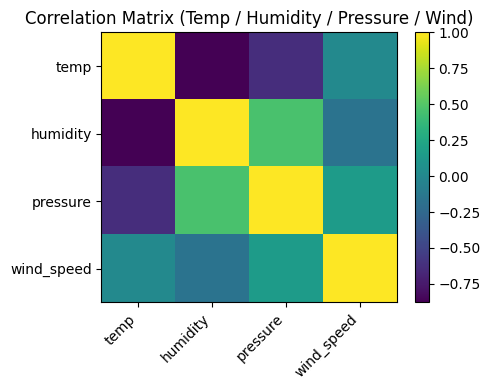

In [24]:
# Plotting correlation matrix
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(corr.values, aspect='auto')
ax.set_xticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticks(range(len(corr.index)))
ax.set_yticklabels(corr.index)
plt.title("Correlation Matrix (Temp / Humidity / Pressure / Wind)")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


### 14) Heatmap — Avg Hourly Temp by City (matplotlib)

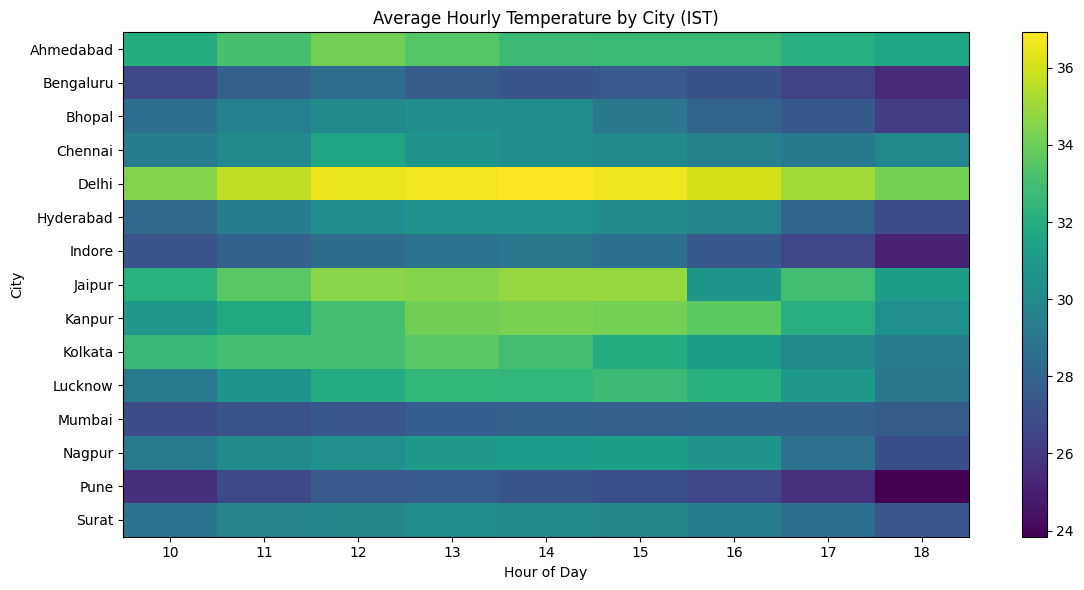

In [25]:

# Pivoting to city x hour
pivot = hourly.pivot(index='city', columns='hour', values='avg_temp').sort_index()
fig, ax = plt.subplots(figsize=(12,6))
im = ax.imshow(pivot.values, aspect='auto')
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns)
plt.title("Average Hourly Temperature by City (IST)")
plt.xlabel("Hour of Day")
plt.ylabel("City")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


### 15) Hourly Temperature Trend — Example City

Downloading: 100%|██████████|


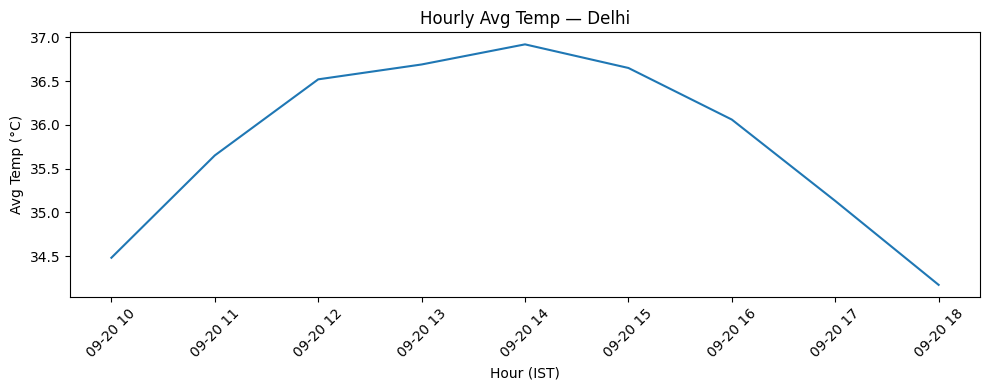

In [26]:

trend_city = run_q(f"""
SELECT DATETIME_TRUNC(ts_ist, HOUR) AS hour, AVG(temp) AS avg_temp
FROM `{FULL_TABLE}`
WHERE city = "{CITY_EXAMPLE}"
GROUP BY hour
ORDER BY hour
""")
plt.figure(figsize=(10,4))
plt.plot(trend_city['hour'], trend_city['avg_temp'])
plt.title(f"Hourly Avg Temp — {CITY_EXAMPLE}")
plt.xlabel("Hour (IST)")
plt.ylabel("Avg Temp (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
